# Data Project: Analyse Employment Shares of Regions in Denmark 

## 1.1 Import data 

Firstly we import the relevant packages that we will use throught out the whole project. 

In [35]:
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')

We import the table RAS201 from Statistics Denmark by using the pydst package. All variables are imported, which is specified by the '*'. 

In [36]:
Emp = dst.get_data(table_id = 'RAS201', variables = {'OMRÅDE':['*'], 'TID':['*'], 'ALDER':['*'], 'HERKOMST':['*'], 'KØN':['*'], 'SOCIO': ['*']})

Emp.head()

,OMRÅDE,TID,ALDER,HERKOMST,KØN,SOCIO,INDHOLD
0,Horsens,2014,Under 16 years,Descendants from non-western countries,Women,Outside the labour force,509
1,Horsens,2011,Under 16 years,Descendants from non-western countries,Men,Outside the labour force,489
2,Horsens,2012,Under 16 years,Descendants from non-western countries,Men,Outside the labour force,501
3,Horsens,2013,Under 16 years,Descendants from non-western countries,Men,Outside the labour force,490
4,Aarhus,2012,35-39 years,Descendants from non-western countries,Women,Employed,36


## 1.2 Delete and rename columns 

We are interested in looking at the development in the overall employment share in the different regions of Denmark and compare it with the employment share for Denmark in total. Thus we delete the columns age, gender and ancestry since we are not interested in these. 

In [37]:
for v in ['ALDER', 'KØN', 'HERKOMST']: 
    del Emp[v]

Furthermore we rename the remaining variables (columns). 

In [38]:
Emp = Emp.rename(columns = {'TID':'Year', 'OMRÅDE': 'Region', 'SOCIO': 'Status', 'INDHOLD': 'Num_pers'})

Emp.head()

,Region,Year,Status,Num_pers
0,Horsens,2014,Outside the labour force,509
1,Horsens,2011,Outside the labour force,489
2,Horsens,2012,Outside the labour force,501
3,Horsens,2013,Outside the labour force,490
4,Aarhus,2012,Employed,36


## 1.3 Aggregate data 

We would like to aggregate the data such that we have the employment share in each region (and in all Denmark) pr. year pr. social economical status.
This is done by firstly using a Regex code to create a new variable that only contains rows that are either a 'Region' or 'All Denmark'. 

In [39]:
I = Emp['Region'].str.contains(r'^(?:(?!Region|All Denmark).)*$') 

We now delete all columns that are not a Region or All Denmark. 

In [40]:
Emp.drop(Emp[I].index, inplace=True)    

Emp.head()

,Region,Year,Status,Num_pers
3048,Region Nordjylland,2008,Outside the labour force,5
3049,Region Nordjylland,2009,Outside the labour force,3
3050,Region Nordjylland,2010,Outside the labour force,4
3051,Region Nordjylland,2008,Outside the labour force,5
3052,Region Nordjylland,2009,Outside the labour force,3


#### Delete people outside labour force

To calculate the employment share we should remove all persons outside the labour force. 
To delete people outside the labour force we create a new variable only containing rows where people are employed or unemployed

In [41]:
Inside_LF = Emp['Status']!='Outside the labour force'
LF = Emp[Inside_LF]

#### Aggregate data

We can now aggregate our data to region per year for different socioeconomical status (employed or unemployed) or Denmark in total per year per socioeconomical status. This is done by aggregating over our new variable LF that only contains people in the labour force. 

In [42]:
Agg_Emp = LF.groupby(['Region', 'Year', 'Status'])['Num_pers'].sum().reset_index()

Agg_Emp.head()

,Region,Year,Status,Num_pers
0,All Denmark,2008,Employed,2844814
1,All Denmark,2008,Unemployed,64209
2,All Denmark,2009,Employed,2725724
3,All Denmark,2009,Unemployed,130058
4,All Denmark,2010,Employed,2704542


## 1.4 Calcalute Employment shares 

We calculate the employment share in each region and in All Denmark by dividing the total number of employed people with the total number of people in the labour force. 

Firstly we create a new table with the total number of persons in each region and all Denmark. 

In [43]:
TOT = Agg_Emp.groupby(['Region', 'Year'])['Num_pers'].sum()
TOT.head()

Region       Year
All Denmark  2008    2909023
             2009    2855782
             2010    2836600
             2011    2824217
             2012    2820038
Name: Num_pers, dtype: int64

Secondly we create a table with the sum of employees in each region and in all Denmark. 

In [44]:
Status_Emp = Agg_Emp['Status'] == 'Employed'

Agg_Emp_New = Agg_Emp[Status_Emp]

TOT_Emp = Agg_Emp_New.groupby(['Region', 'Year']).sum()

#### Join tables together 

We can now join the two newly created tables together by merging on the variables Region and Year. 

In [45]:
JoinTotal = pd.merge(TOT_Emp.reset_index(),TOT.reset_index(),how='inner',on=['Region','Year'])
JoinTotal.head()

,Region,Year,Num_pers_x,Num_pers_y
0,All Denmark,2008,2844814,2909023
1,All Denmark,2009,2725724,2855782
2,All Denmark,2010,2704542,2836600
3,All Denmark,2011,2698418,2824217
4,All Denmark,2012,2684840,2820038


We rename some of the columns. 

In [46]:
JoinTotal = JoinTotal.rename(columns = {'Num_pers_x':'Employed', 'Num_pers_y':'Population'})

##### We can now calculate the employment share 

In [47]:
JoinTotal['Employ_share'] = JoinTotal.Employed/JoinTotal.Population*100

## 1.5 Create Line chart

To get an overview of the development in the employment shares of the different regions we create a line chart. 

Region
All Denmark           AxesSubplot(0.125,0.125;0.775x0.755)
Region Hovedstaden    AxesSubplot(0.125,0.125;0.775x0.755)
Region Midtjylland    AxesSubplot(0.125,0.125;0.775x0.755)
Region Nordjylland    AxesSubplot(0.125,0.125;0.775x0.755)
Region Sjælland       AxesSubplot(0.125,0.125;0.775x0.755)
Region Syddanmark     AxesSubplot(0.125,0.125;0.775x0.755)
Name: Employ_share, dtype: object

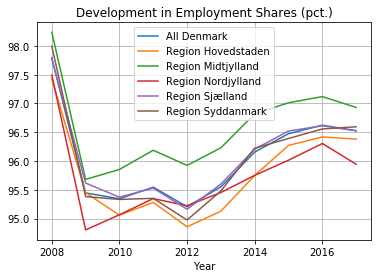

In [48]:
JoinTotal.set_index('Year').groupby('Region')['Employ_share'].plot(legend=True, grid=True, title='Development in Employment Shares (pct.)')

We have also create a line chart with a dropdown menu where it is possible to only look at one variable at the time. This gives the opportunity to look at the development in each region or in all Denmark individually. 

In [49]:
from ipywidgets import interact
def draw_graph(region):
    Graph_Data = JoinTotal.loc[JoinTotal['Region'] == region,:]
    Graph_Data.set_index('Year').groupby('Region')['Employ_share'].plot(legend=True, grid=True, title='Development in Employment Shares (pct.)')
    return

# Next we create an interactive line chart which displays the development of employment shares grouped by the regions of Denmark
interact(draw_graph, region=['All Denmark', 'Region Syddanmark','Region Sjælland','Region Nordjylland','Region Midtjylland','Region Hovedstaden'])


interactive(children=(Dropdown(description='region', options=('All Denmark', 'Region Syddanmark', 'Region Sjæl…

<function __main__.draw_graph(region)>

## 1.6 Conclusion

The main conclusion of the analysis is, that the delevopment of the employment shares follows the same pattern throughout all regions of Denmark. All Regions were noticeably influenced by the Financial Crisis in 2008-2009 where the employment shares fell in all regions. Yet as shown in the line charts Region Midtjylland in general has a higher level of employment whereas Region Nordjylland seems to have the most volatile development of the regions, compared to the employment share in All Denmark.